In [1]:
!git clone https://github.com/dalmia/David-Silver-Reinforcement-learning.git

Cloning into 'David-Silver-Reinforcement-learning'...
remote: Enumerating objects: 346, done.
remote: Total 346 (delta 0), reused 0 (delta 0), pack-reused 346 (from 1)
Receiving objects: 100% (346/346), 22.39 MiB | 23.18 MiB/s, done.
Resolving deltas: 100% (160/160), done.


In [13]:
import gym
import numpy as np
import matplotlib
import sys
from collections import defaultdict

%matplotlib inline

if "/content/David-Silver-Reinforcement-learning" not in sys.path:
    sys.path.append("/content/David-Silver-Reinforcement-learning")
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
env = gym.make('Blackjack-v1')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [16]:
def create_random_policy(nA):
    """
    Creates a random policy function.

    Args:
        nA: Number of actions in the environment.

    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [17]:
def create_greedy_policy(Q, epsilon):
    """
    Creates a greedy policy based on Q values with epsilon-greedy exploration.

    Args:
        Q: A dictionary that maps from state -> action values
        epsilon: The probability to select a random action. Float between 0 and 1.

    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    def policy_fn(observation):
        action_values = Q[observation]
        nA = len(action_values)

        # Create epsilon-greedy policy
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(action_values)
        A[best_action] += (1.0 - epsilon)

        return A

    return policy_fn

In [18]:
def mc_control_importance_sampling(env, num_episodes, behaviour_policy, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.

    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
        epsilon: The probability to select a random action. Float between 0 and 1.

    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """

    # Number of actions
    nA = env.action_space.n

    # Action Value function to be returned
    Q = defaultdict(lambda: np.zeros(nA))

    # The optimal policy to be returned
    policy = create_greedy_policy(Q, epsilon)

    # store the number of times each state-action pair is visited
    returns_num = defaultdict(float)

    for episode in range(1, num_episodes + 1):

        if episode % 100000 == 0:
            print('Running episode #{}...'.format(episode))

        # store the eligibility trace corresponding to each state-action pair for each episode
        eligibility_traces = defaultdict(float)

        # store the reward corresponding to each state-action for each episode
        episode_rewards = defaultdict(float)

        terminated = False
        state = env.reset()

        # termination condition
        while not terminated:

            # sample the action from the epsilon greedy policy
            action_probabilities = behaviour_policy(state)
            action = np.random.choice(np.arange(len(action_probabilities)), p=action_probabilities)

            # perform the action in the environment
            next_state, reward, terminated, _ = env.step(action)

            # update the eligibility trace for the state-action pairs already visited in the episode
            for (_state, _action) in eligibility_traces:
                eligibility_traces[(_state, _action)] *= discount_factor

            # add a new state-action pair to the dictionary if it's not been visited before
            if (state, action) not in eligibility_traces:
                eligibility_traces[(state, action)] = 1.0
                returns_num[(state, action)] += 1

            # update the reward for each state-action pair
            for (_state, _action) in eligibility_traces:
                # since the action of the action chosen for the current state is 1 for our target
                # policy (since it is a greedy policy), we can simply divide by the
                # action value corresponding to the behaviour policy
                episode_rewards[(_state, _action)] += eligibility_traces[(_state, _action)] * reward / behaviour_policy(state)[action]

            # update the current state
            state = next_state

        # update the action value function using incremental mean method
        for (state, action) in episode_rewards:
            Q[state][action] += (episode_rewards[(state, action)] - Q[state][action]) / returns_num[(state, action)]

        # Policy Improvement
        policy = create_greedy_policy(Q, epsilon)

    return Q, policy

In [20]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behaviour_policy=random_policy)

Running episode #100000...
Running episode #200000...
Running episode #300000...
Running episode #400000...
Running episode #500000...


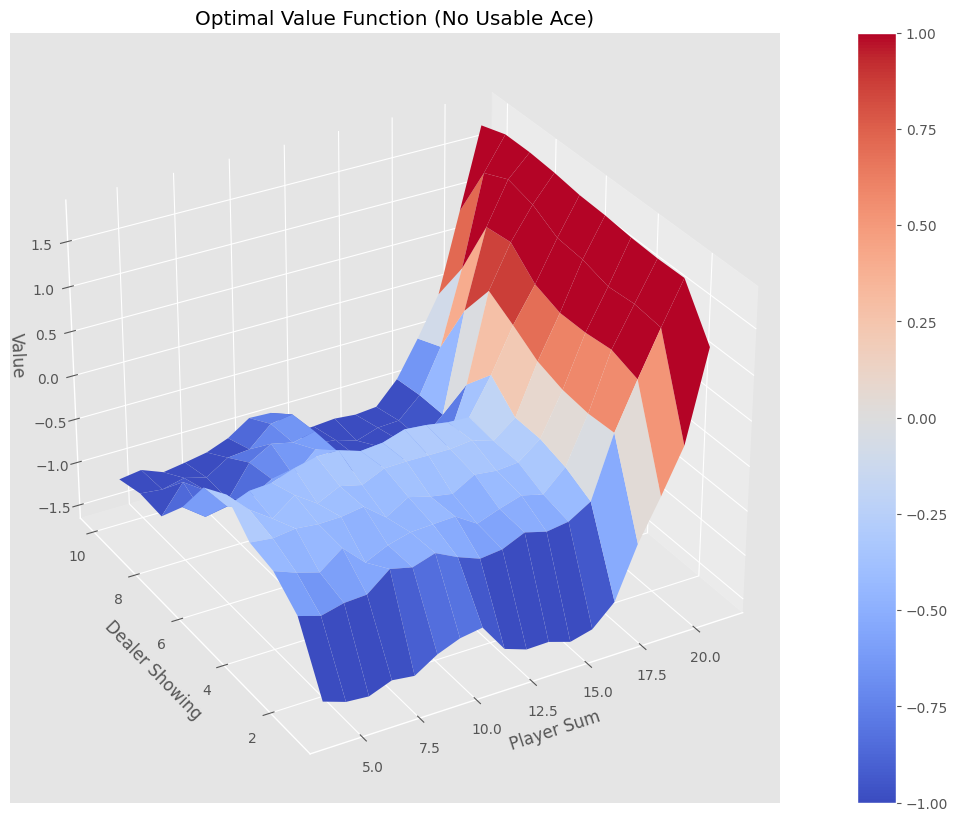

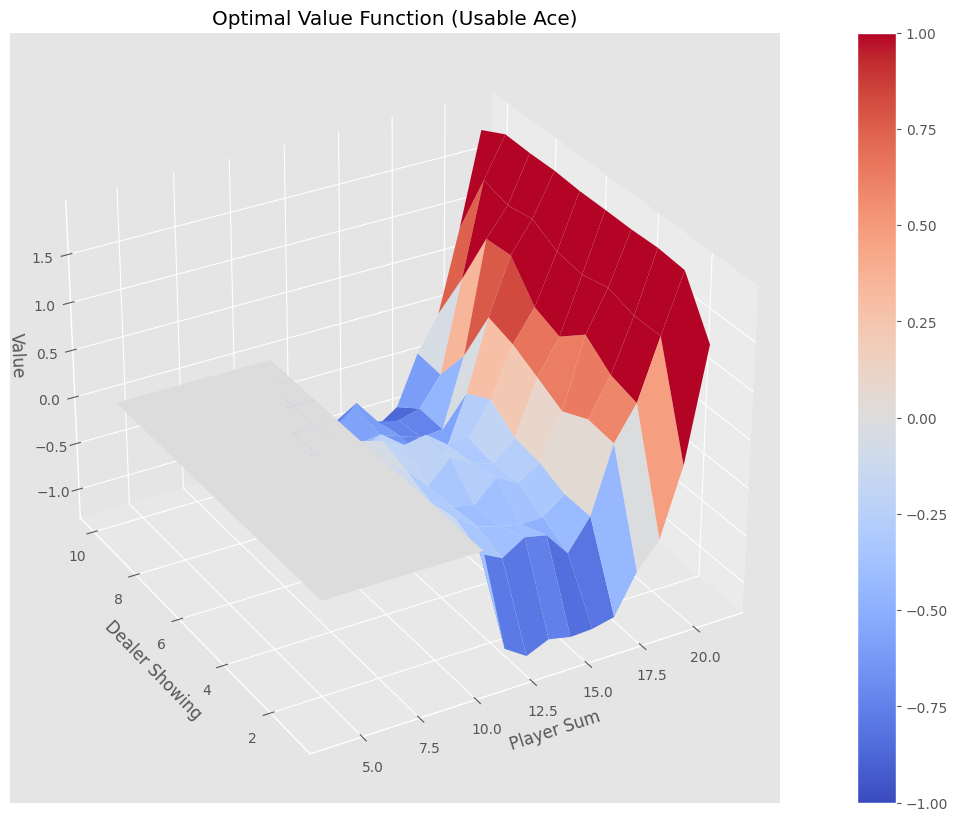

In [22]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")